In [97]:
# EMC2 WP 2 Processing 1.1  
# Filter on buildings with no dwellings  
# Author : Perez Joan

# Prerequisites : output from 0.1 (department) or 0.2 (subset on a municipality)

In [1]:
# 0.1 Packages, local filepaths & parameters
import geopandas as gpd
from shutil import copy

# Specify the location of output from 0.1 (main) or 0.2 (subset)
gpkg = "C:\\Users\\jperez\\Documents\\Current 1\\emc2\\Output\\WP2_DPC_0.2_Subset.gpkg"
# Specify the file path to record the results
gpkg_save = "C:\\Users\\jperez\\Documents\\Current 1\\emc2\\Output\\WP2_DPC_1.1_Subset.gpkg"

# Read the data
building = gpd.read_file(gpkg, layer="building")
activity_area = gpd.read_file(gpkg, layer="activity_area")

In [3]:
# 1. Spatial join of categories of activity areas to buildings

building = building.rename(columns={'index_right': 'index_rgt'})
activity_area = activity_area.rename(columns={'index_right': 'index_rgt'})
building = gpd.sjoin(building, activity_area[['categorie', 'geometry']], how='left', predicate='intersects')                                

In [4]:
# 2. Indexes to remove

# light buildings
indexes_1 = building[(building["construction_legere"] == True) & (building["nombre_de_logements"].isnull())].index
# Building with no dwelling
indexes_2 = building[building["nombre_de_logements"] == 0].index
# Specialized buildings
indexes_3 = building[(building["nature"] != "Indifférenciée") & (building["nombre_de_logements"].isnull())].index
# Building under construction (not in service)
indexes_4 = building[building["etat_de_l_objet"] != "En service"].index
# Annex buildings (official definition : Petit bâtiment à vocation d'annexe au sens fiscal : garage externe, abri...)
indexes_5 = building[(building["usage_1"] == "Annexe") & (building["nombre_de_logements"].isnull())].index
# Buildings with less the 10 m² of footprint 
indexes_6 = building[building.geometry.area < 10].index
# Large buildings within specialized areas with NULL values of dwellings
indexes_7 = building[(building.geometry.area > 150) & (building["nombre_de_logements"].isnull()) & (~building["categorie"].isnull())].index

In [5]:
# 3. merge indexes, remove duplicates & perform the filter

merged_idx = indexes_1.union(indexes_2).union(indexes_3).union(indexes_4).union(indexes_5).union(indexes_6).union(indexes_7)
filtered_building = building.drop(merged_idx)

In [6]:
# 4. Write a layer of buildings with dwellings (NA included) in output file

filtered_building.to_file(gpkg_save, layer="Buildings_with_dwellings_NA_included", driver="GPKG")

In [8]:
# Appendices
import contextily
import folium
from folium.plugins import MarkerCluster
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import matplotlib.pyplot as plt

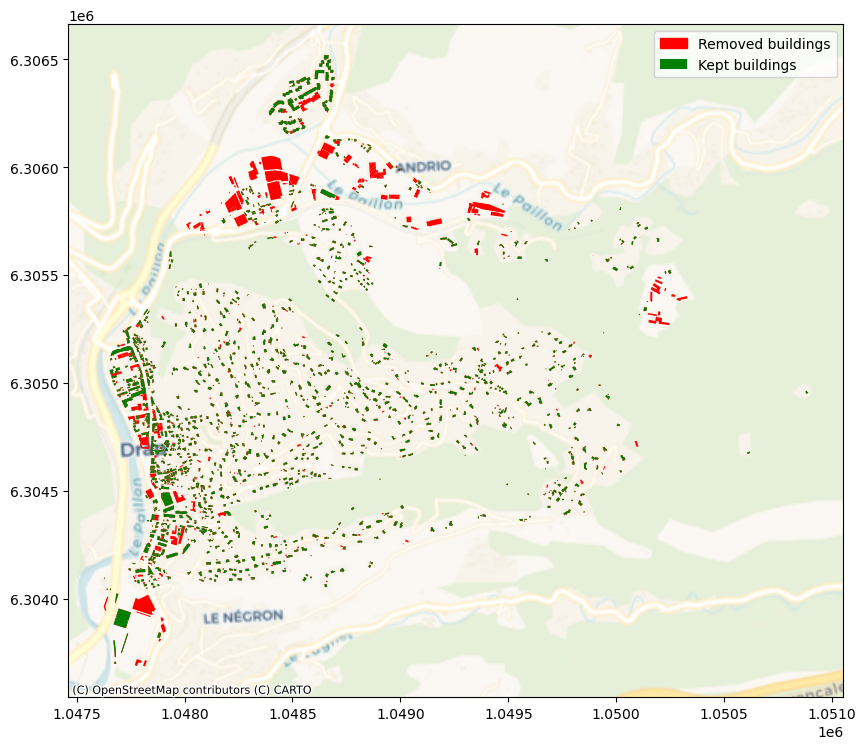

In [9]:
# Appendix A1 : Map of kept/removed buildings
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, color='red', label='Removed buildings'), 
    plt.Rectangle((0, 0), 1, 1, fc='green', label='Kept buildings')
]
# Plot removed buildings in red
ax = building.plot(figsize=(10, 10), color='red')
# Plot kept buildings in green
filtered_building.plot(ax=ax, color='green')
# Add legend & basemap
ax.legend(handles=legend_handles)
contextily.add_basemap(ax, crs=filtered_building.crs, source=contextily.providers.CartoDB.Voyager)

In [10]:
# Appendix A2 : Interactive map of kept/removed buildings
# Removed and kept buildings - Mapview
from ipyleaflet import Map, GeoData, basemaps, LayersControl, Polygon
map = folium.Map(location=[43.7544, 7.3208], tiles="OpenStreetMap", zoom_start=14.5)
folium.GeoJson(building, color = "red").add_to(map)
folium.GeoJson(filtered_building, color = "green").add_to(map)
map